In [1]:
# Kaggle Spaceship Titanic
# Author: Ishank Jain

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# IterativeImputer is only available in scikit-learn 0.21, which as of April 2019 is only released as a developer version,
# not as stable. Therefore, added first import statement. Takes long time
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

C:\Users\ishan\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Save to data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [4]:
# check columns for missing data
print(train.isna().sum())

# Check if duplicate data is present in train data
print(f'Duplicates in train set: {train.duplicated().sum()}')

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
Duplicates in train set: 0


Text(0.5, 0, 'Age (yrs)')

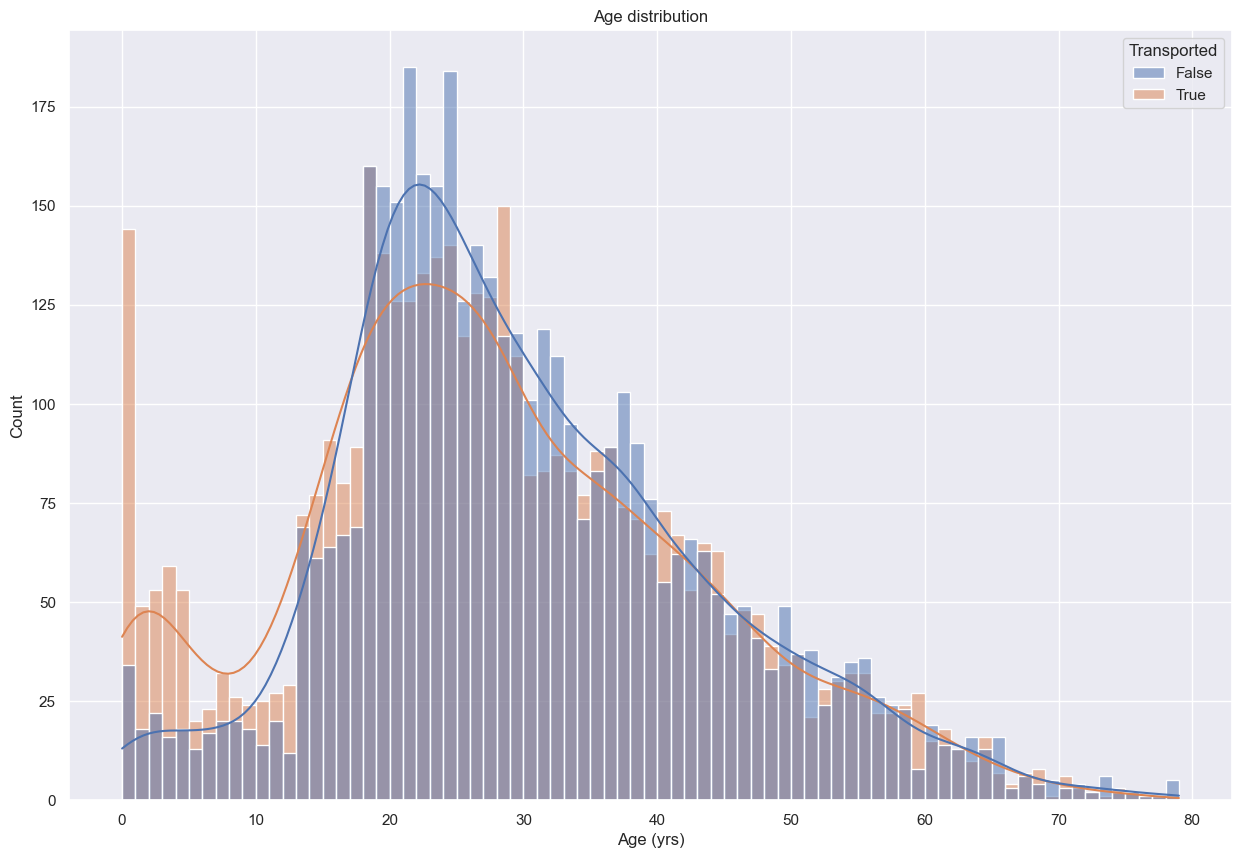

In [5]:
# Exploratory data analysis

# Figure size
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
# Histogram and  kde curve
sns.histplot(data=train, x='Age', hue='Transported', binwidth=1, kde=True)

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (yrs)')

Observations:

    People of age 0-18 year were more likely to be transported than not.
    People of age 19-38 year were less likely to be transported.
    People of age 38-49 year were more likely to be transported than not.
    People over 49 year olds were about equally likely to be transported than not.

Inference:

    Create a new category column based on above groups.



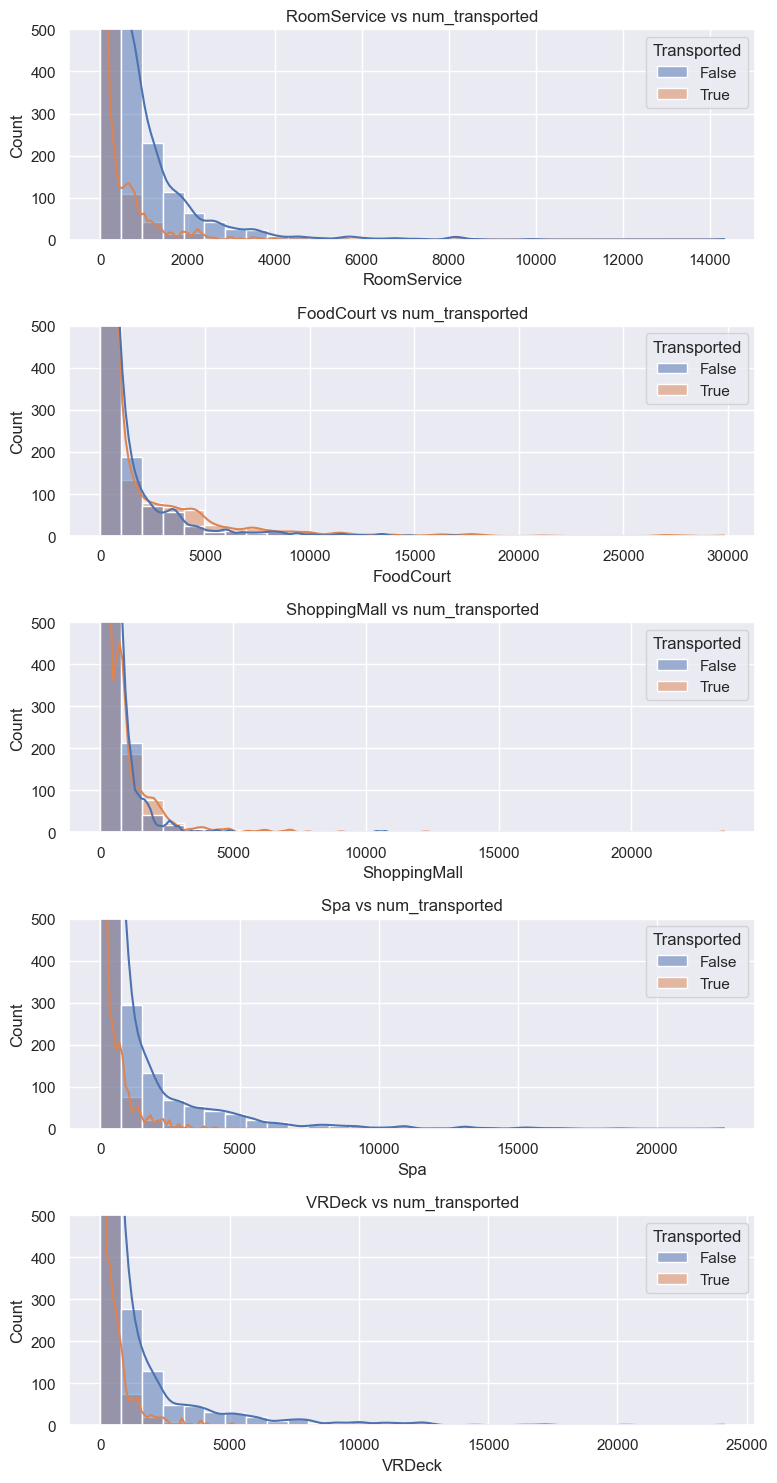

In [6]:
# Explore expenses
expenses_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig=plt.figure(figsize=(15,15))

# Plot expenditure features
for i, var_name in enumerate(expenses_feats):

    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,500])
    ax.set_title(var_name + " vs num_transported")
fig.tight_layout()
plt.show()

Observations:

    Large number of people don't spend any money.
    People who were transported tended to spend less.

Inference:

    Create a new feature that tracks the total expenditure across all 5 amenities.
    Create a binary feature to indicate if the person has not spent anything. (i.e. total expenditure is 0).

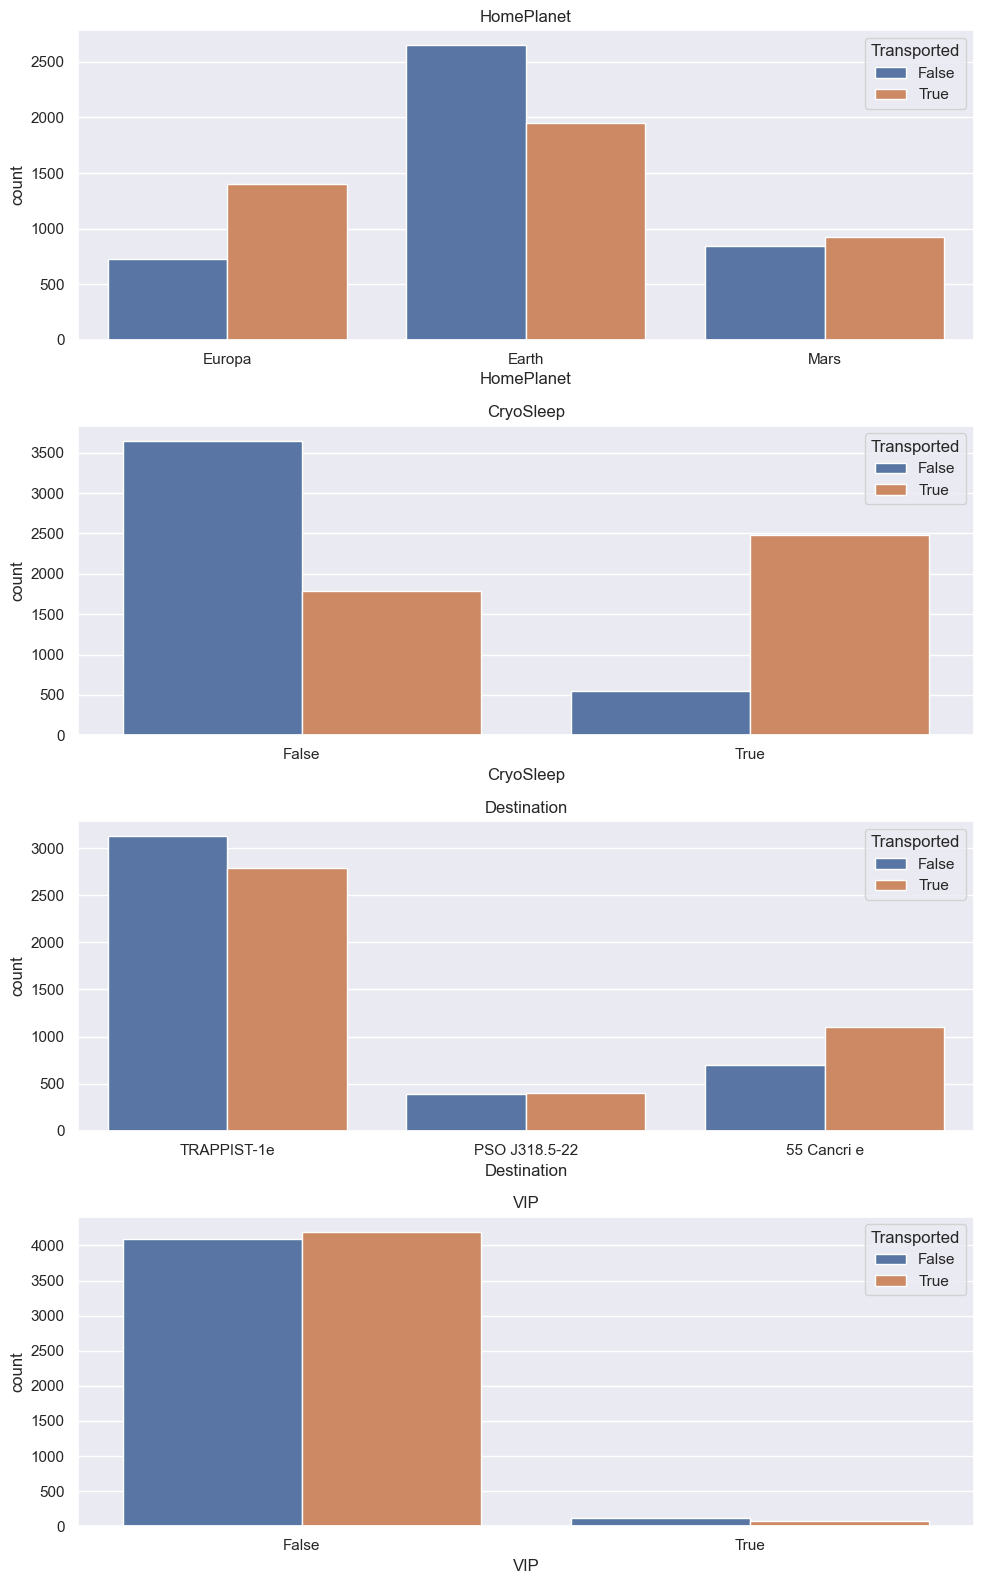

In [7]:
# Categorical features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

Observations:

    VIP does not appear to be a useful feature; the target split is more or less equal.
    One may drop the VIP column to prevent overfitting.



In [8]:
def data_modeling(df: pd.DataFrame):
    '''
    Based on above observations apply the inferences to prepare final data to run model.
    '''
    # New features
    df['Age_group']=np.nan
    df.loc[(train['Age']<=18),'Age_group']='Age_0-18'
    df.loc[(train['Age']>18) & (df['Age']<=38),'Age_group']='Age_18-38'
    df.loc[(train['Age']>38) & (train['Age']<=49),'Age_group']='Age_38-49'
    df.loc[train['Age']>=50,'Age_group']='Age_50+'
    
    # New features - training set
    df['Expenditure']=df[expenses_feats].sum(axis=1)
    df['No_spending']=(df['Expenditure']==0).astype(int)
    
    # split cabin
    df[['Cabin_1','Cabin_2','Cabin_3']] = df.Cabin.str.split("/", expand = True)
    
    # drop column that offers no benefit to model
    df= df.drop(['Name','Age', 'PassengerId', 'Cabin'],axis=1)
    
    return df

In [9]:
X_train = data_modeling(train)
X_test = data_modeling(test)

In [10]:
X_train.head()

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Age_group,Expenditure,No_spending,Cabin_1,Cabin_2,Cabin_3
0,Europa,False,TRAPPIST-1e,False,0.0,0.0,0.0,0.0,0.0,False,Age_38-49,0.0,1,B,0,P
1,Earth,False,TRAPPIST-1e,False,109.0,9.0,25.0,549.0,44.0,True,Age_18-38,736.0,0,F,0,S
2,Europa,False,TRAPPIST-1e,True,43.0,3576.0,0.0,6715.0,49.0,False,Age_50+,10383.0,0,A,0,S
3,Europa,False,TRAPPIST-1e,False,0.0,1283.0,371.0,3329.0,193.0,False,Age_18-38,5176.0,0,A,0,S
4,Earth,False,TRAPPIST-1e,False,303.0,70.0,151.0,565.0,2.0,True,Age_0-18,1091.0,0,F,1,S


Text(0.5, 1.0, 'Age group distribution')

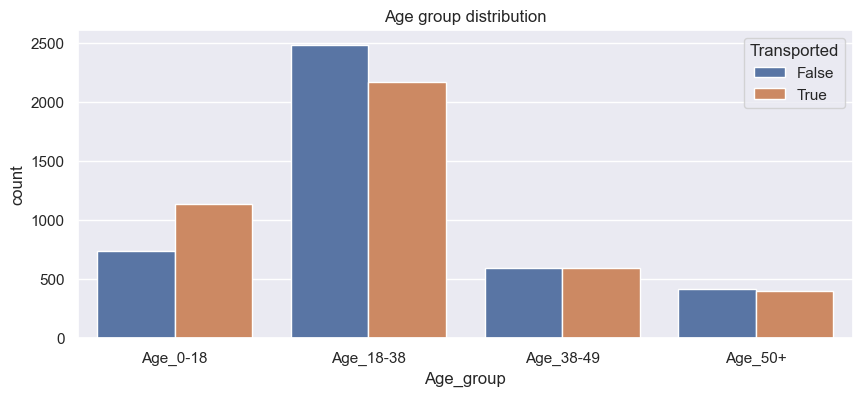

In [11]:
# Plot distribution of new features
plt.figure(figsize=(10,4))
g=sns.countplot(data=X_train, x='Age_group', hue='Transported', order=['Age_0-18','Age_18-38','Age_38-49','Age_50+'])
plt.title('Age group distribution')

  Age_38-49 does not appear to be a useful feature; the split is more or less equal.
  One may drop the Age_38-49 column to prevent overfitting.

In [12]:
# remove target column from training data
target=X_train['Transported'].copy().astype(int)
X=X_train.drop('Transported', axis=1).copy()

X.head()

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Age_group,Expenditure,No_spending,Cabin_1,Cabin_2,Cabin_3
0,Europa,False,TRAPPIST-1e,False,0.0,0.0,0.0,0.0,0.0,Age_38-49,0.0,1,B,0,P
1,Earth,False,TRAPPIST-1e,False,109.0,9.0,25.0,549.0,44.0,Age_18-38,736.0,0,F,0,S
2,Europa,False,TRAPPIST-1e,True,43.0,3576.0,0.0,6715.0,49.0,Age_50+,10383.0,0,A,0,S
3,Europa,False,TRAPPIST-1e,False,0.0,1283.0,371.0,3329.0,193.0,Age_18-38,5176.0,0,A,0,S
4,Earth,False,TRAPPIST-1e,False,303.0,70.0,151.0,565.0,2.0,Age_0-18,1091.0,0,F,1,S


### Preprocessing: Fix missing value and transform Categorical Columns

In [13]:
# Select numerical columns
numeric_columns=list(X_train.select_dtypes(include=np.number).columns)
# Select Categorical  columns
cat_columns=X_train.select_dtypes(include=['object']).columns.tolist()

In [14]:
# Scale numerical data to have mean=0 and variance=1
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode categorical data
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore',sparse=False))])

# Combine preprocessing
ct = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_columns),
        ('cat', cat_transformer, cat_columns)],
        remainder='passthrough')

# Apply preprocessing
X_processed_train = pd.DataFrame(ct.fit_transform(X))
X_processed_test = pd.DataFrame(ct.transform(X_test))

C:\Users\ishan\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [15]:
X_processed_train.head()

,0,1,2,3,4,5,6,7,8,9,...,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855
0,-0.337025,-0.284274,-0.287317,-0.273736,-0.266098,-0.514066,1.174601,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.173528,-0.278689,-0.245971,0.209267,-0.227692,-0.251479,-0.851353,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.272527,1.934922,-0.287317,5.634034,-0.223327,3.190333,-0.851353,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.337025,0.511931,0.326250,2.655075,-0.097634,1.332604,-0.851353,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.117466,-0.240833,-0.037590,0.223344,-0.264352,-0.124824,-0.851353,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


1. SimpleImputer: Fill missing values in the data with different statistical properties like mean, median and most frequent.

2. KNNImputer: Fills missing values using k-Nearest Neighbors.

3. IterativeImputer: That estimates each feature from all the others.

In [16]:
# Prefered solution is to use IterativeImputer but it takes quite a long time to execute.  
# itr_imp = IterativeImputer(random_state=0)

itr_imp = SimpleImputer()
imputed = itr_imp.fit_transform(X_processed_train)
df_imputed_train = pd.DataFrame(imputed, columns=X_processed_train.columns)

df_imputed_train.head()

,0,1,2,3,4,5,6,7,8,9,...,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855
0,-0.337025,-0.284274,-0.287317,-0.273736,-0.266098,-0.514066,1.174601,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.173528,-0.278689,-0.245971,0.209267,-0.227692,-0.251479,-0.851353,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.272527,1.934922,-0.287317,5.634034,-0.223327,3.190333,-0.851353,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.337025,0.511931,0.326250,2.655075,-0.097634,1.332604,-0.851353,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.117466,-0.240833,-0.037590,0.223344,-0.264352,-0.124824,-0.851353,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
imputed_test = itr_imp.transform(X_processed_test)
df_imputed_test = pd.DataFrame(imputed_test, columns=X_processed_test.columns)

df_imputed_test.head()

,0,1,2,3,4,5,6,7,8,9,...,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855
0,-0.337025,-0.284274,-0.287317,-0.273736,-0.266098,-0.514066,1.174601,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.337025,-0.278689,-0.287317,2.209903,-0.266098,0.496322,-0.851353,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.337025,-0.284274,-0.287317,-0.273736,-0.266098,-0.514066,1.174601,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.337025,3.843828,-0.287317,-0.114494,0.244530,2.132494,-0.851353,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.322026,-0.284274,0.762859,-0.273736,-0.266098,-0.283945,-0.851353,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
# Define the model : initially I was running only 1 model
# my_model = RandomForestClassifier(random_state=0, verbose=False)
# Fit the model
# my_model.fit(df_imputed_train, target)
# Predict
# pred = my_model.predict(df_imputed_test)

In [44]:
# Classifiers
classifiers = {
    "RandomForest" : RandomForestClassifier(random_state=0),
    "XGBoost" : XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss'), # XGBoost takes too long
    "LGBM" : LGBMClassifier(random_state=0),
    "CatBoost" : CatBoostClassifier(random_state=0, verbose=False)
}

# Grids for grid search
# learning rate in the range of 0.1 to 0.3 gives the best results.
rf_grid = {'n_estimators': [100, 200, 500, 1000],
           'max_depth': [4, 8, 12],
           "criterion": "log_loss"
          }

boosted_grid = {'n_estimators': [100, 200, 300, 400],
                'max_depth': [4, 8, 12],
                'learning_rate': [0.1, 0.2, 0.3]
               }

# Dictionary of all grids
grid = {
        "RandomForest" : rf_grid,
        "XGBoost" : boosted_grid,
        "LGBM" : boosted_grid,
        "CatBoost" : boosted_grid
       }

In [20]:
# It is helpful when we are using Boosting etc as valid can be used to find right parameters for early stopping
from sklearn.model_selection import train_test_split, GridSearchCV

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(df_imputed_train, target, train_size=0.9, test_size=0.1, random_state=0)

In [45]:
# {Classifier: best_parameters} 
clf_best_params={}
# {Classifer: 'Validation accuracy i.e. score'}
perf_scores={}

# loop over all classifiers
for key, classifier in classifiers.items():
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_train_full, y_train)
    perf_scores[key]=clf.score(X_valid_full, y_valid)

    # Save trained model
    clf_best_params[key]=clf.best_params_

### Choose model with best score and use it to run final pred

In [46]:
# get model with highest accuracy i.e. score
best_model = max(perf_scores, key=perf_scores.get)

In [47]:
# change parameter dtype from int to list
best_parameters=clf_best_params[best_model]
for keys in best_parameters:
        best_parameters[keys] = [best_parameters[keys]]

In [48]:
clf = GridSearchCV(estimator=classifiers[best_model], param_grid=clf_best_params[best_model], n_jobs=-1, cv=None)

# Train and score
clf.fit(df_imputed_train, target)
pred=clf.predict(df_imputed_test)

In [49]:
# convert array to df
pred = pd.DataFrame(pred)
# replace
pred=pred.replace({0:False, 1:True})
# fix column names
pred['PassengerId'] = test['PassengerId']
pred = pred.rename(columns={0: 'Transported'})

In [50]:
# save to file
from pathlib import Path  

filepath = Path('submission.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
pred.to_csv(filepath, index=False)  

#### Potential issues

1. The ability to run data through onehotencoder and standardscalar might lead to wayward results on test set (real world) [Data Leakage]

2. StandardScalar might not be optimal for normalizing data

3. OnehotEncoder introduces tons on new columns which might lead to slower models especially boosting models. One might try ordinalEncoder (OE), but OE itself comes with its own set of issues.

4. I submitted RandomForestClassifier results to Kaggle as other classifiers were taking way too much time. Only other model which completed running was XGBoost, but was very slow even on Colab.

5. My Score: 0.79401